In [ ]:
# if needed run this
#from dustmaps.config import config
#config.reset()

In [100]:
#local section (shar)

import sys
sys.path.insert(0, "/lustre/lrspec/metrics")
sys.path.insert(0, "/home/3155/metrics/Multi_Transient_Metrics_Hub")

import os
os.environ["RUBIN_SIM_DATA_DIR"] = "/lustre/lrspec/metrics/rubin_sim_data"

db_dir = "/lustre/lrspec/metrics/"

In [94]:
%matplotlib inline
import sys
import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
sys.path.append(os.path.abspath(".."))
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim import maf
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp
from scipy.stats import truncnorm


from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [122]:
import importlib


# Clear the module from cache
if "local_GRBafterglows_metric" in sys.modules:
    del sys.modules["local_GRBafterglows_metric"]

# Re-import and reload the updated module
import local_GRBafterglows_metric
importlib.reload(local_GRBafterglows_metric)

# Import updated classes and functions from the refactored module
from local_GRBafterglows_metric import (
    GRBAfterglowLC,
    GRBAfterglowDetectMetric,
    GRBAfterglowBetterDetectMetric,
    generateGRBPopSlicer,
    GRBAfterglowSpecTriggerableMetric,
    GRBAfterglowCharacterizeMetric,
    GRBAfterglowColorEvolveMetric,
    GRBAfterglowHistoricalMatchMetric,
    generateGRBAfterglowTemplates
)



# Confirm path
print(local_GRBafterglows_metric.__file__)

# Filter utility: select events within t_start and t_end range
def filter_population_by_time(slicer, t_start, t_end):
    peak_times = slicer.slice_points['peak_time']
    mask = (peak_times >= t_start) & (peak_times < t_end)

    ra_new = slicer.slice_points['ra'][mask]
    dec_new = slicer.slice_points['dec'][mask]

    new_slicer = UserPointsSlicer(ra=ra_new, dec=dec_new, badval=0)

    # Copy all fields
    new_slicer.slice_points = {k: v[mask] for k, v in slicer.slice_points.items()}

    # Overwrite sid to ensure alignment with metric index
    new_slicer.slice_points['sid'] = np.arange(len(new_slicer.slice_points['ra']))

    return new_slicer

/home/3155/metrics/Multi_Transient_Metrics_Hub/GRBafterglows/local_GRBafterglows_metric.py


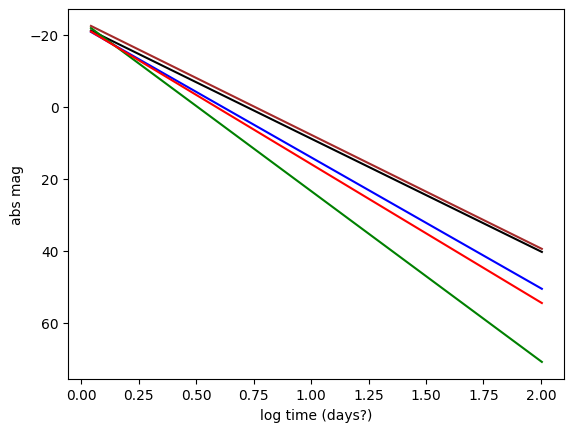

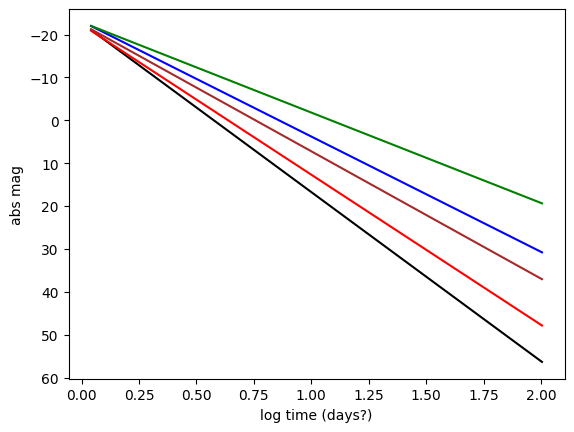

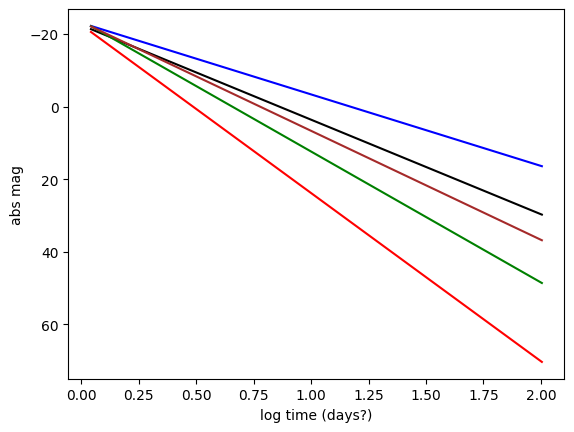

In [124]:
lcdict = pickle.load(open("GRBAfterglow_templates.pkl", "rb"))
for i in range(3):
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                     lcdict["lightcurves"][i]['u']['mag'], color='k')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                      lcdict["lightcurves"][i]['g']['mag'], color='b')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                      lcdict["lightcurves"][i]['r']['mag'], color='g')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                      lcdict["lightcurves"][i]['i']['mag'], color='r')
    plt.plot(np.log10(lcdict["lightcurves"][i]['u']['ph']+1e-5),
                    lcdict["lightcurves"][i]['z']['mag'], color='brown')
    ylims = plt.ylim()
    plt.xlabel("log time (days?)")
    plt.ylabel("abs mag")
    plt.ylim(*ylims[::-1])
    plt.show()

In [125]:
#all configs
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
rate_density = 1e-8
rate_str = f"rd{rate_density:.0e}".replace("-", "m")  # Example: 1e-8 to rd1e-8
filters = ['u', 'g', 'r', 'i', 'z', 'y']
grbs_dir = f"GRBafterglows_fixedpop_detectonly/{rate_str}"
grb_templates_file = "GRBAfterglow_templates.pkl"
grb_pop_file = os.path.join(grbs_dir, f"GRB_population_fixedpop_10yr_{rate_str}.pkl")
dmin, dmax = 10, 1000
gal_lat_cut = None
os.makedirs(grbs_dir, exist_ok=True)
# db_dir = "../"


t_start = 1
t_end = 3652

# ---- Template Setup ----
if not os.path.exists(grb_templates_file):
    from local_GRBafterglows_metric import generateGRBAfterglowTemplates
    generateGRBAfterglowTemplates(save_to=grb_templates_file)
shared_lc_model = GRBAfterglowLC(load_from=grb_templates_file)

# ---- Population Setup ----
if not os.path.exists(grb_pop_file):
    slicer = generateGRBPopSlicer(
        t_start=t_start, t_end=t_end, seed=42,
        d_min=dmin, d_max=dmax, num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut, rate_density=rate_density,
        save_to=grb_pop_file
    )
else:
    slicer = generateGRBPopSlicer(load_from=grb_pop_file)

n_events = len(slicer.slice_points['distance'])

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB population from GRBafterglows_fixedpop_detectonly/rd1em08/GRB_population_fixedpop_10yr_rd1em08.pkl


## All 10 years


--- Running four_roll_v4.3.1_10yrs ---
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 754
mag_obs         | type: <class 'numpy.ndarray'> | length: 754
snr_obs         | type: <class 'numpy.ndarray'> | length: 754
filter          | type: <class 'numpy.ndarray'> | length: 754
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 419
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float64'> | value: 62323.386917571996
peak_mag        | typ

/tmp/ipykernel_57031/2324048688.py:76: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 419 simulated GRB events, Rubin detected 4 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.0 ± 0.0 filters.


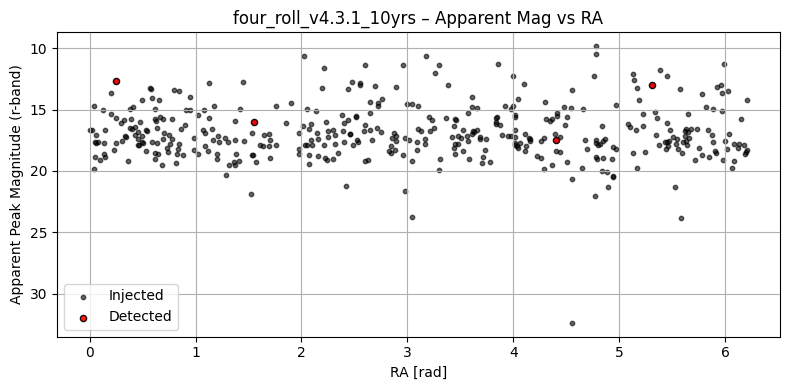

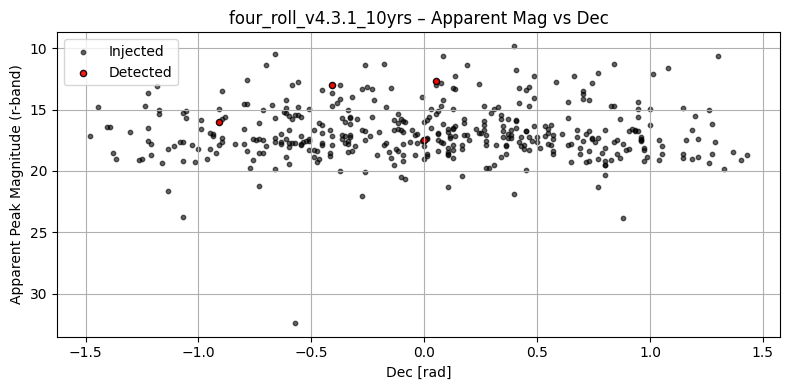

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


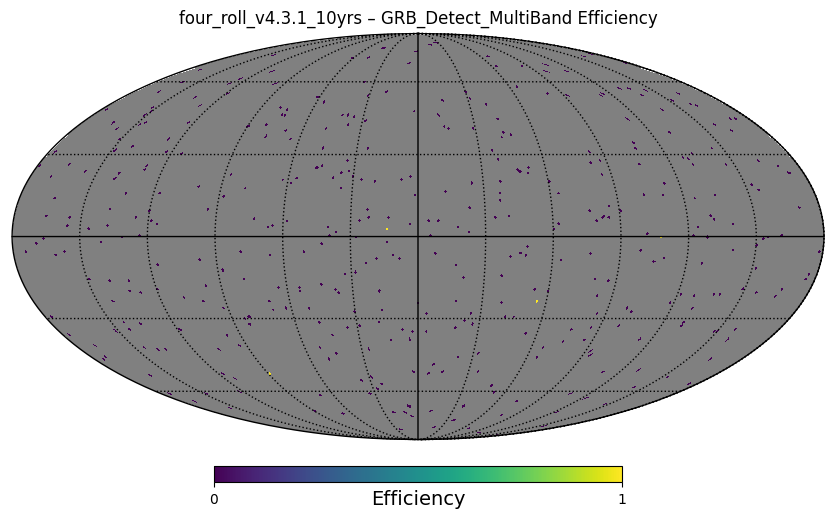

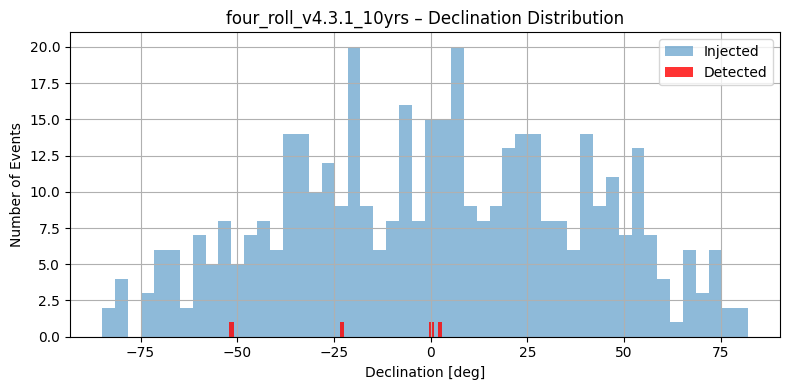

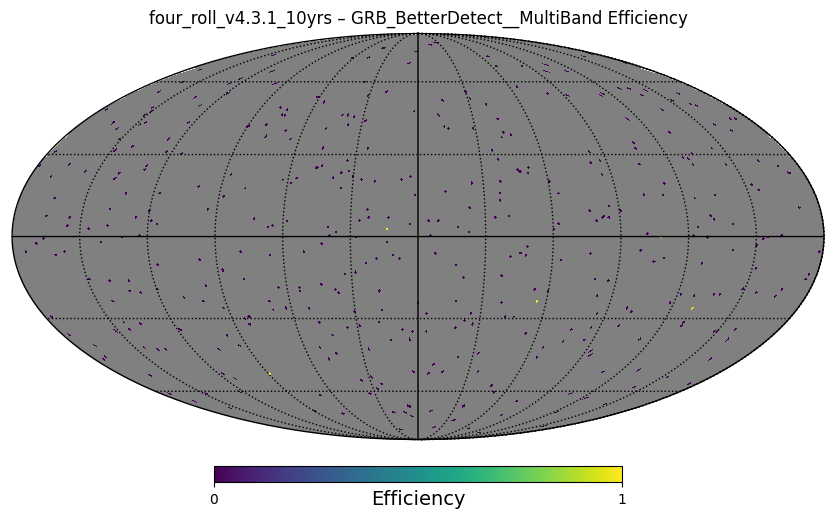

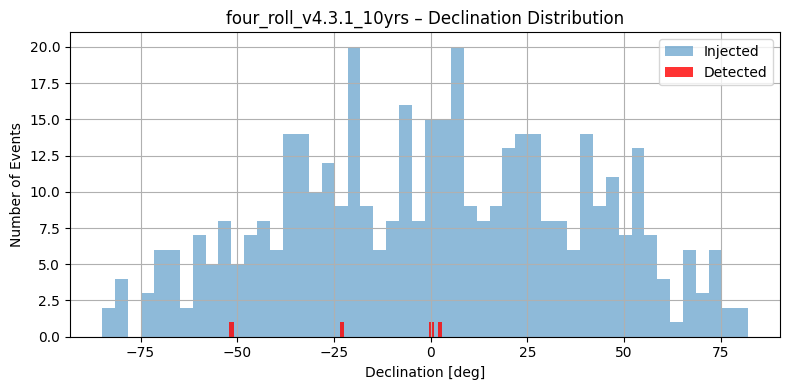

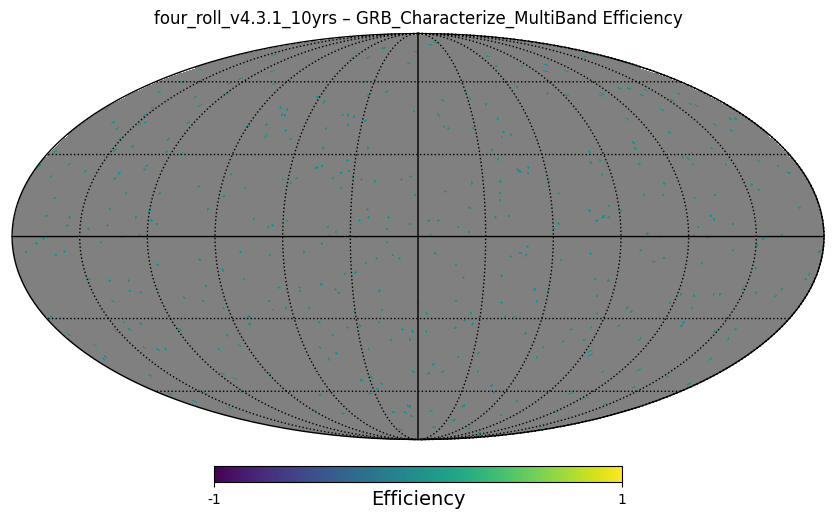

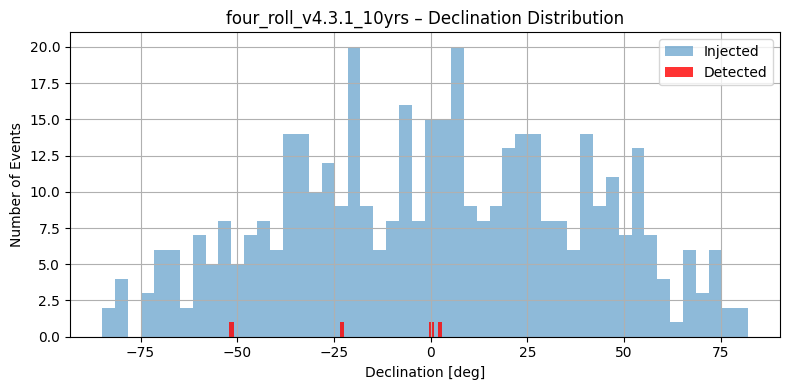

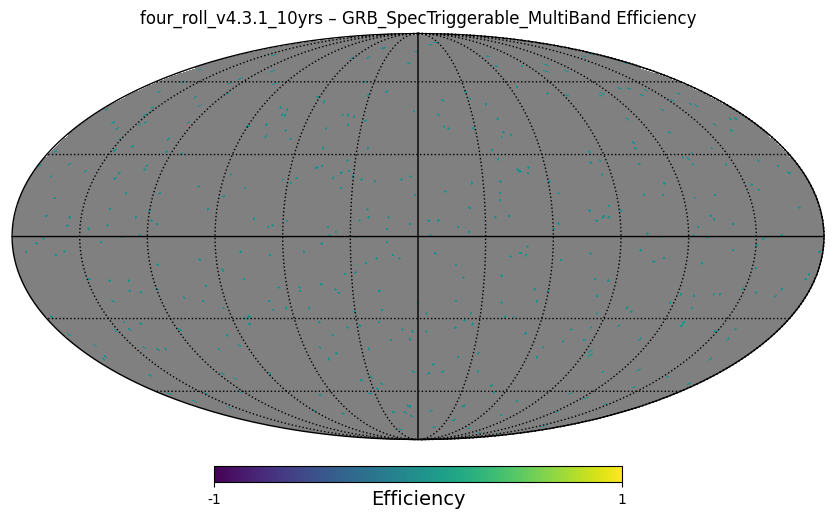

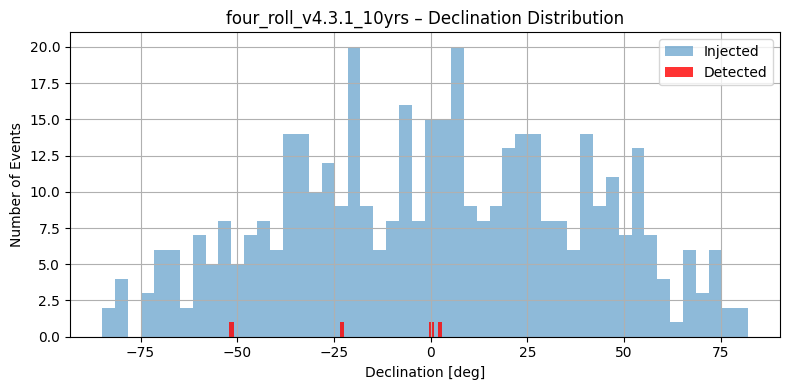

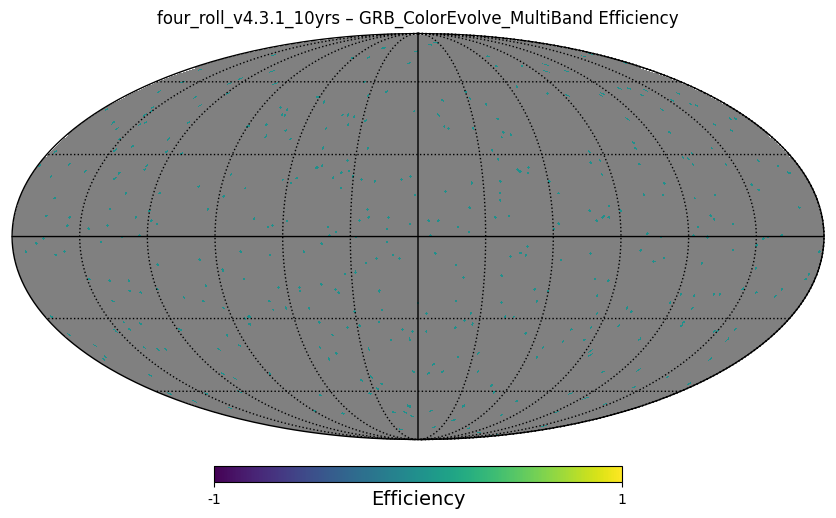

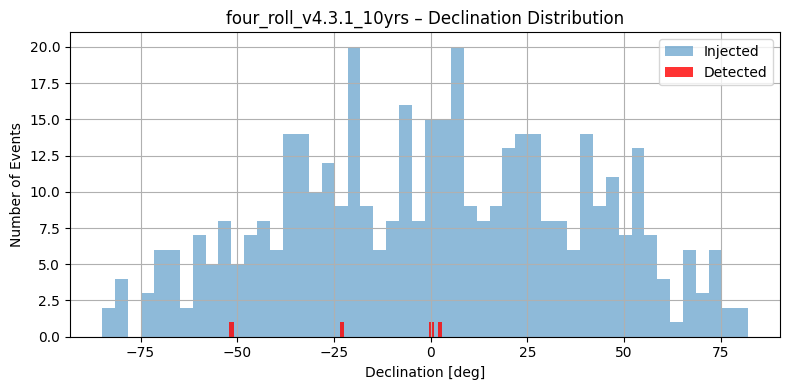

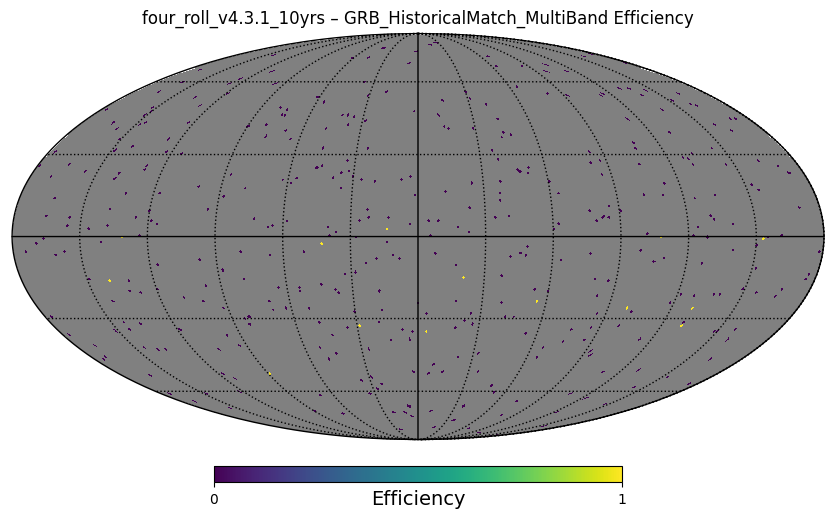

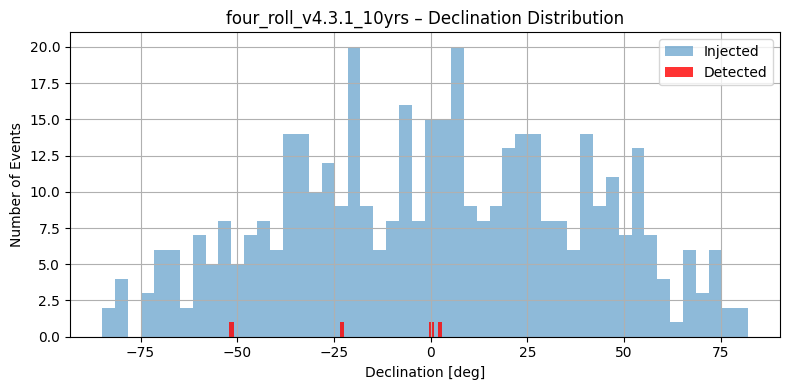

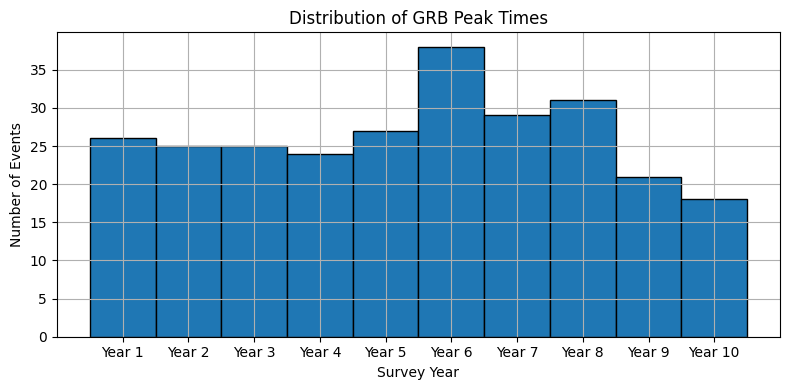


--- Running baseline_v4.3.1_10yrs ---
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl

Inspecting one obs_record before saving to CSV:
mjd_obs         | type: <class 'numpy.ndarray'> | length: 778
mag_obs         | type: <class 'numpy.ndarray'> | length: 778
snr_obs         | type: <class 'numpy.ndarray'> | length: 778
filter          | type: <class 'numpy.ndarray'> | length: 778
first_det_mjd   | type: <class 'float'> | value: nan
last_det_mjd    | type: <class 'float'> | value: nan
fade_time_days  | type: <class 'float'> | value: nan
sid             | type: <class 'numpy.int64'> | value: 1
file_indx       | type: <class 'numpy.int64'> | value: 419
ra              | type: <class 'numpy.float64'> | value: 0.6135923151542564
dec             | type: <class 'numpy.float64'> | value: -0.5848608108840141
distance_Mpc    | type: <class 'numpy.float64'> | value: 444.4896553545318
peak_mjd        | type: <class 'numpy.float64'> | value: 63906.25227580979
peak_mag        | type:

/tmp/ipykernel_57031/2324048688.py:76: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 419 simulated GRB events, Rubin detected 4 under the baseline_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of 1.0 ± 0.0 filters.


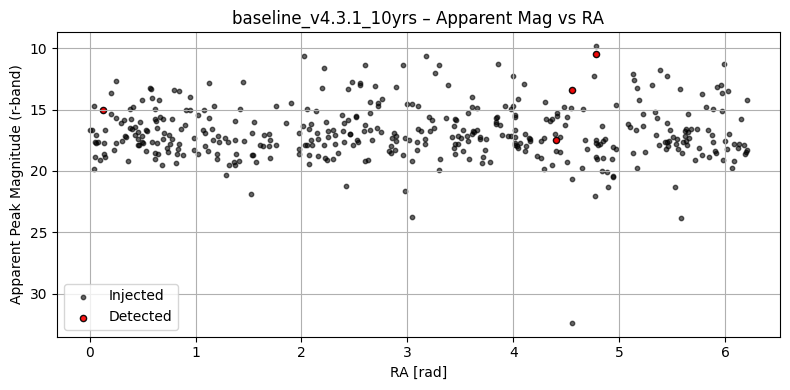

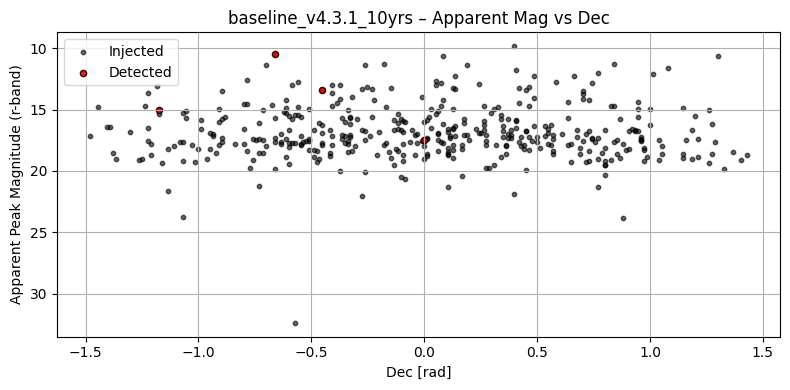

Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


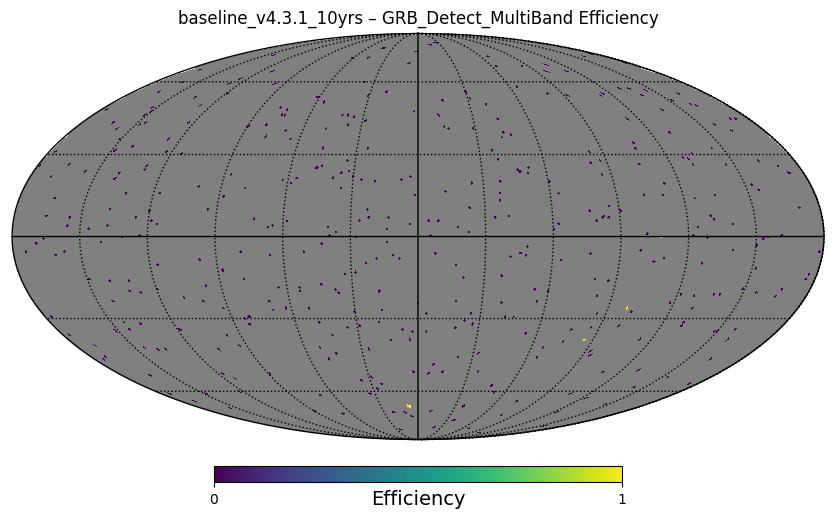

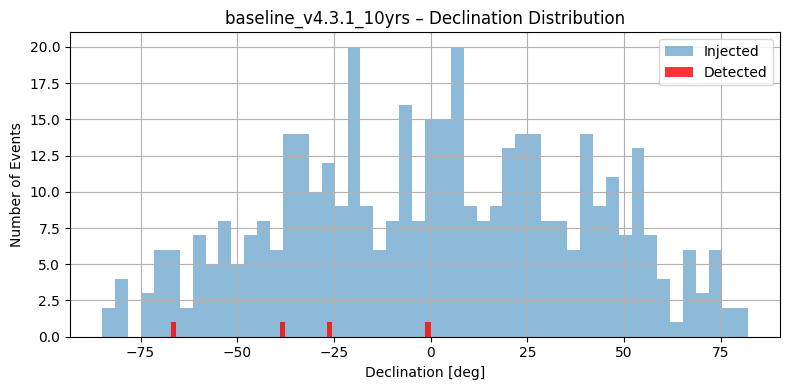

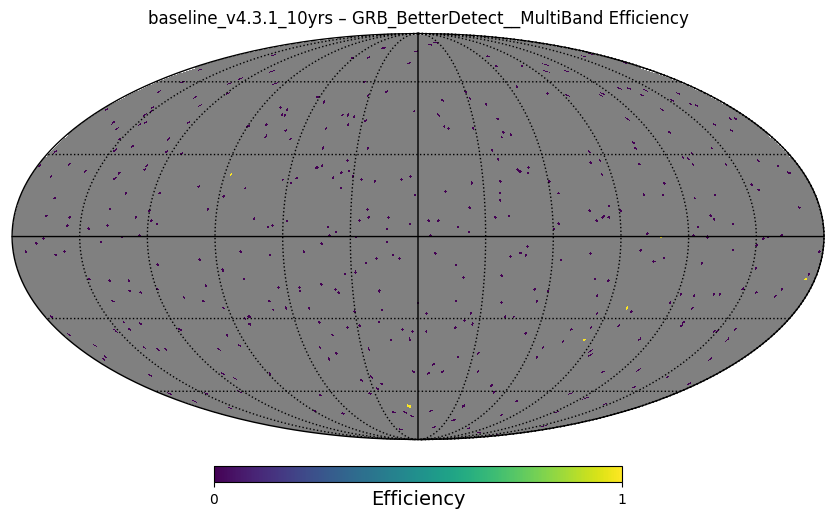

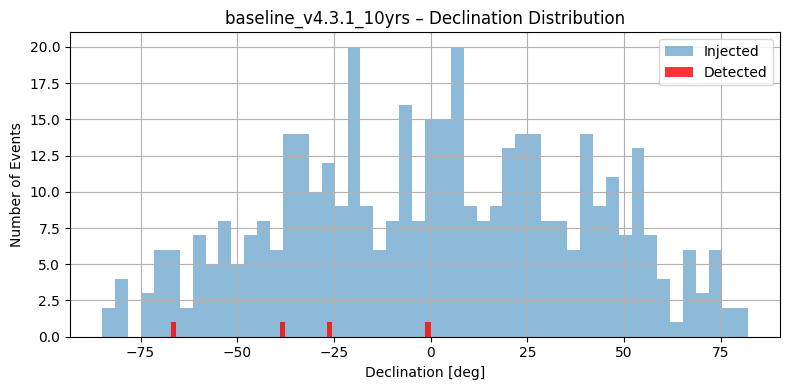

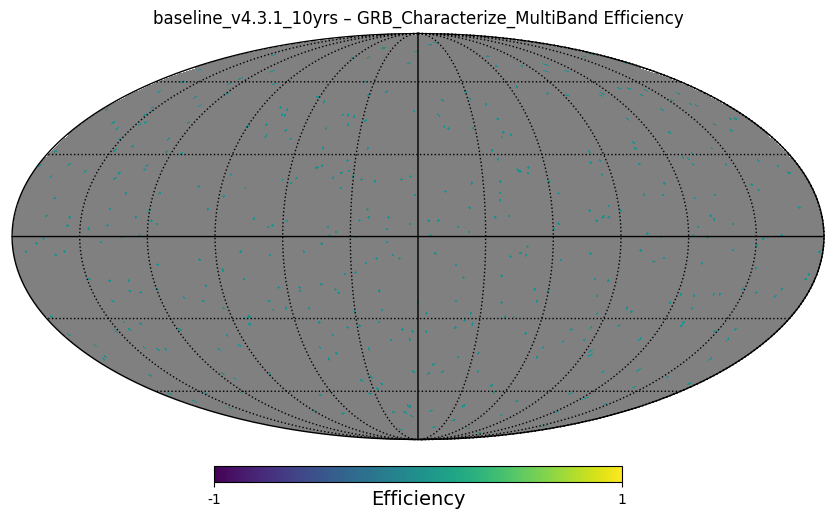

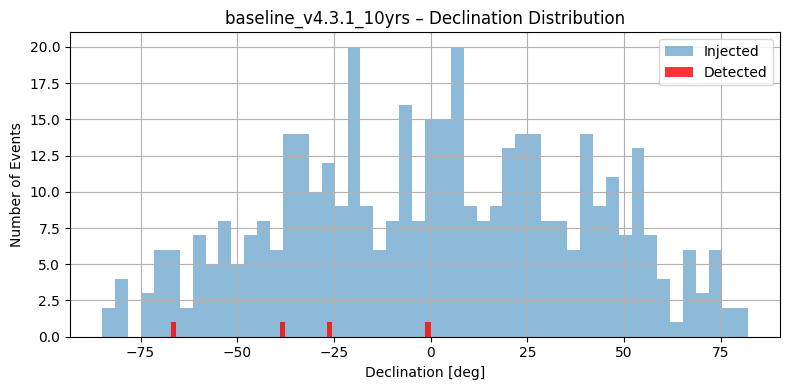

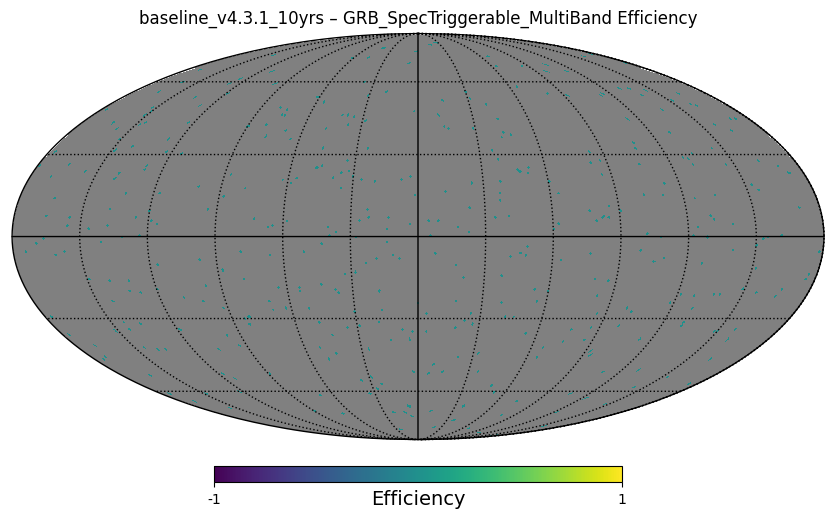

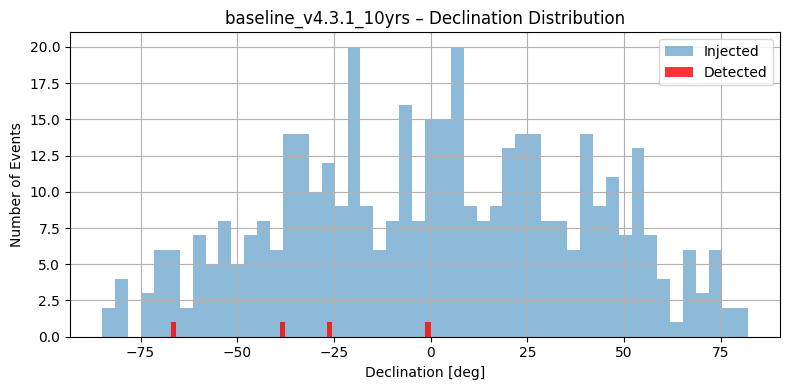

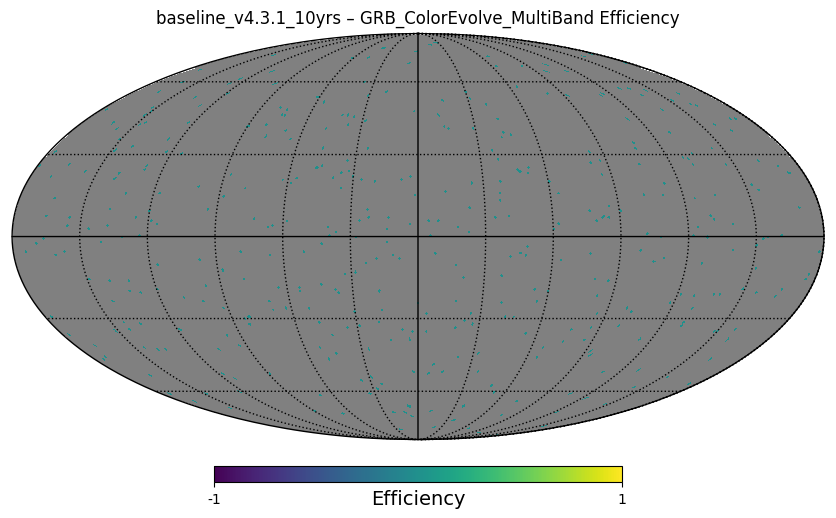

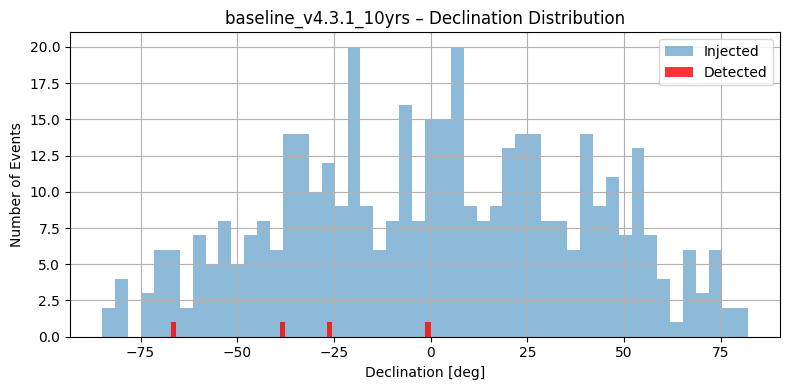

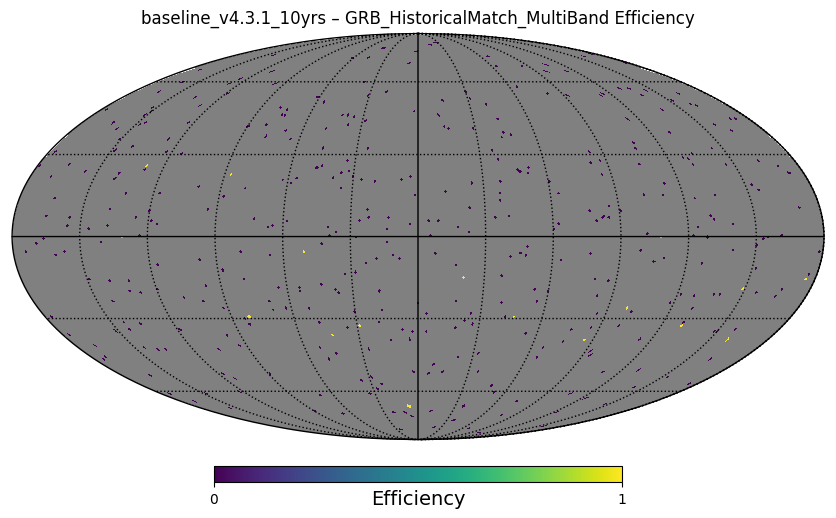

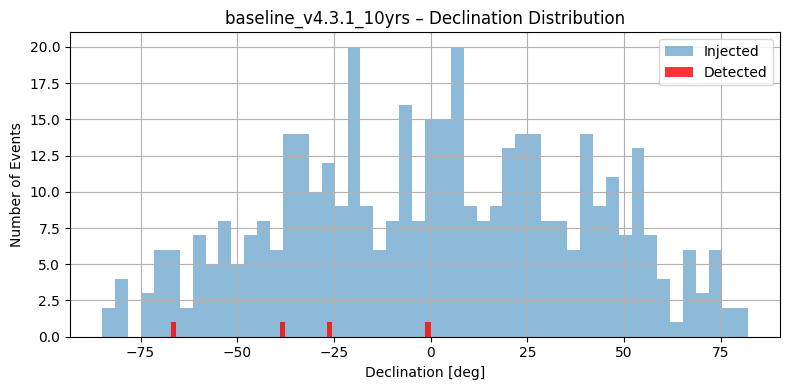

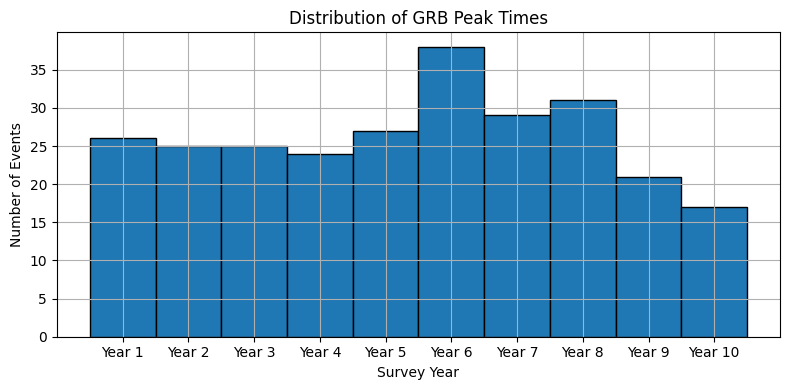

In [126]:
# ---- ALL 10 years Configuration ----
first = 1
for cadence in cadences:
    runName = cadence
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(grbs_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)

    print(f"\n--- Running {cadence} ---")

    #### per filter metric here
    per_filter_metrics = OrderedDict()
    filters = ['all']
    for filt in filters:
        detect = GRBAfterglowDetectMetric(metricName=f"GRB_Detect_{filt}", #filter_include=[filt], 
                                         lc_model=shared_lc_model)
                    #GRBAfterglowSpecTriggerableMetric(metricName=f"GRB_Detect_{filt}", filter_include=[filt], 
                    #                      lc_model=shared_lc_model)
        per_filter_metrics[f"GRB_Detect_{filt}"] = metric_bundles.MetricBundle(detect, slicer, '')

    pf_group = metric_bundles.MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()

        # save obs_data
    bundle = per_filter_metrics["GRB_Detect_all"]
    
    # Pull the actual metric instance used inside the bundle
    detect_metric = bundle.metric

    #get results
    obs_records = list(detect_metric.obs_records.values())

    #Error checking 1
    print("\nInspecting one obs_record before saving to CSV:")
    sample_record = obs_records[0]
    for key, val in sample_record.items():
        print(f"{key:15} | type: {type(val)}", end='')
        try:
            print(f" | length: {len(val)}")
        except TypeError:
            print(f" | value: {val}")

    #Error checking 2
    print("\nChecking consistency across all obs_records...")
    keys = obs_records[0].keys()
    for key in keys:
        lengths = [len(v[key]) if hasattr(v[key], '__len__') and not isinstance(v[key], str) else 1 for v in obs_records]
        if len(set(lengths)) > 1:
            print(f" Inconsistent lengths in field '{key}': {set(lengths)}")
    
    
    # Now get the results
    df_obs = pd.DataFrame.from_dict(detect_metric.obs_records).T
    df_obs = df_obs.reset_index().rename(columns={"index": "sid"})

    df_obs_arr = pd.DataFrame.from_dict(detect_metric.obs_records).T.reset_index().rename(columns={"index": "sid"})

    # =======================================================================
    # Add calendar year assuming MJD0 = 59853.5 (LSST start)
    # Convert peak MJD to years since LSST start (365.25 days/year)
    df_obs["year"] = (df_obs["peak_time"] / 365.25).astype(int) + 1
    df_detected_per_year = df_obs[df_obs['detected'] == True].groupby("year").size().reset_index(name="n_detected")
    # =======================================================================


    # Convert problematic ndarray columns to lists before saving
    for col in ['filter', 'mjd_obs', 'mag_obs', 'snr_obs']:
        df_obs[col] = df_obs[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
    
    # Now save
    df_obs.to_csv(f"GRBafterglows_output/ObsRecords_{cadence}.csv", index=False)


    
    n_filters_detected_per_event = np.array([
        sum(per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1 
            and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
            for f in filters)
        for i in range(n_events)
    ])
    
    detected_mask = n_filters_detected_per_event >= 1
    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
    std_filters = np.std(n_filters_detected_per_event[detected_mask])

    print(f"Out of {n_events} simulated GRB events, Rubin detected {n_detected} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")


    # Plot: Apparent magnitude vs RA and Dec for one filter (e.g. 'r')
    filtername = 'r'
    ax1 = DustValues().ax1
    
    ras, decs, peak_mags, detected_flags = [], [], [], []
    
    for i in range(n_events):
        ra = slicer.slice_points['ra'][i]
        dec = slicer.slice_points['dec'][i]  # this is in radians already
        d = slicer.slice_points['distance'][i]
        ebv = slicer.slice_points['ebv'][i]
        file_indx = slicer.slice_points['file_indx'][i]
        
        m_peak = np.min(shared_lc_model.data[file_indx][filtername]['mag'])
        A = ax1[filtername] * ebv
        dm = 5 * np.log10(d * 1e6) - 5
        m_app = m_peak + dm + A
    
        ras.append(ra)
        decs.append(dec)
        peak_mags.append(m_app)
    
        detected = any(
            per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1
            and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
            for f in filters
        )
        detected_flags.append(detected)

    # Plot: Apparent magnitude vs RA
    
    plt.figure(figsize=(8, 4))
    plt.scatter(ras, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(ras)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("RA [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"{cadence} – Apparent Mag vs RA")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot: Apparent magnitude vs Dec
    plt.figure(figsize=(8, 4))
    plt.scatter(decs, peak_mags, c='black', s=10, label='Injected', alpha=0.6)
    plt.scatter(np.array(decs)[detected_flags], np.array(peak_mags)[detected_flags],
                c='red', s=20, label='Detected', alpha=0.9, edgecolors='black')
    plt.xlabel("Dec [rad]")
    plt.ylabel(f"Apparent Peak Magnitude ({filtername}-band)")
    plt.title(f"{cadence} – Apparent Mag vs Dec")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

    # Optional: save summaries or plot
    outfile = os.path.join(grbs_dir, f"local_efficiency_{cadence}_GRBA.csv")
    with open(outfile, "w") as out:
        out.write("sid,n_filters_detected\n")
        for i in range(n_events):
            out.write(f"{i},{n_filters_detected_per_event[i]}\n")
    
    # Add multi-band metrics
    multi_metrics = [
        GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowBetterDetectMetric(metricName="GRB_BetterDetect__MultiBand", lc_model=shared_lc_model),
        GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
        GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
    ]



    for metric in multi_metrics:
        mb_key = f"{runName}_{metric.__class__.__name__}"
        bundle = metric_bundles.MetricBundle(metric, slicer, '', file_root=mb_key, plot_funcs=[], summary_metrics=[metrics.SumMetric()])
        
        bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
        bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        bgroup.run_all()
        if first:
            df = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            df["run"] = runName
            first = 0
        else:
            _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
            _["run"] = runName            
            df = pd.concat([df, _])
        # Healpix plotting

        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = slicer.slice_points['ra']
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)

        #print(f"[DEBUG] RA range [rad]: {ra_rad.min():.2f} – {ra_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [rad]: {dec_rad.min():.2f} – {dec_rad.max():.2f}")
        #print(f"[DEBUG] Dec range [deg]: {np.degrees(dec_rad).min():.2f} – {np.degrees(dec_rad).max():.2f}")
        
        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            #if detected_flags[i] :
            if bundle.metric_values[i] == 1:
                if np.random.rand() < 0.001:
                    print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN

        hp.mollview(eff_map, title=f"{runName} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()

        plt.figure(figsize=(8, 4))

        plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
        plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
        plt.xlabel("Declination [deg]")
        plt.ylabel("Number of Events")
        plt.title(f"{cadence} – Declination Distribution")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # =======================================================================

    plt.figure(figsize=(8, 4))
    
    years = df_obs["peak_time"] / 365.25
    plt.hist(years, bins=np.arange(0.5, 11.5, 1), edgecolor='black')
    
    plt.xticks(ticks=np.arange(1, 11), labels=[f"Year {i}" for i in range(1, 11)])
    plt.xlabel("Survey Year")
    plt.ylabel("Number of Events")
    plt.title("Distribution of GRB Peak Times")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

        

## Tests

Text(0.5, 0, 'fade time (days)')

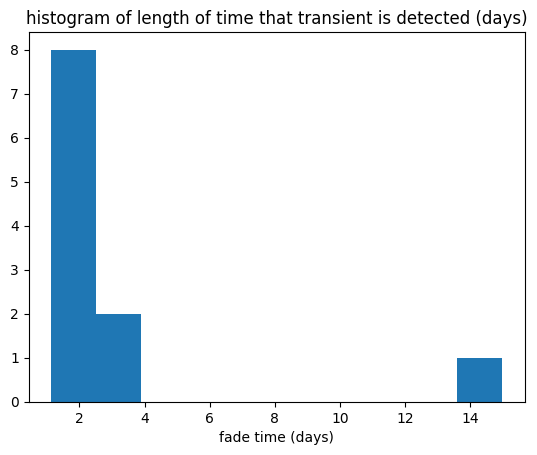

In [127]:
plt.hist(df_obs_arr['fade_time_days'])
plt.title("histogram of length of time that transient is detected (days)")
plt.xlabel("fade time (days)")

In [193]:
def plot_observed_light_curve(row):
    unique_filters = np.unique(row['filter'])
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_filters)))
    filter_to_color = dict(zip(unique_filters, colors))
    color_array = np.array([filter_to_color[f] for f in row['filter']])

    snr_obs_mask = row['snr_obs']>3 #can switch to 5
    markers = ["." , "o" ]
    snr_to_marker = dict(zip(np.array([True,False]), markers))
    marker_array = np.array([snr_to_marker[f] for f in snr_obs_mask])
    # print(snr_obs_mask)
    # print(marker_array)
    # return
    plt.scatter(row['mjd_obs'], row['mag_obs'], c=color_array, marker=marker_array)
    plt.xlim(row['peak_mjd']-10,row['peak_mjd']+100)
    plt.legend(["each color is a unique filter"])
    plt.title("Light curve as observed")
    plt.xlabel("MJD")
    plt.ylabel("Apparent Mag")
    plt.show()

In [210]:
def plot_observed_light_curve(row):
    unique_filters = np.unique(row['filter'])
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_filters)))
    filter_to_color = dict(zip(unique_filters, colors))
    color_array = np.array([filter_to_color[f] for f in row['filter']])


    snr_obs_mask = row['snr_obs'] > 3  # Can change threshold here
    snr_to_marker = {False: '.', True: 'o'}

    # plt.figure(figsize=(10, 6))

    # Loop over each filter and SNR condition
    for snr_cond in [True, False]:
            mask = (snr_obs_mask == snr_cond)
            if np.any(mask):  # Only plot if there are matching points
                plt.scatter(
                    row['mjd_obs'][mask],
                    row['mag_obs'][mask],
                    c=color_array[mask],
                    marker=snr_to_marker[snr_cond]
                )

    plt.xlim(row['peak_mjd'] - 10, row['peak_mjd'] + 100)
    plt.gca().invert_yaxis()
    plt.xlabel("MJD")
    plt.ylabel("Apparent Mag")
    plt.title("Light curve as observed")
    plt.legend(["large means detected",
                "each color is a filter"])
    plt.tight_layout()
    plt.show()


4


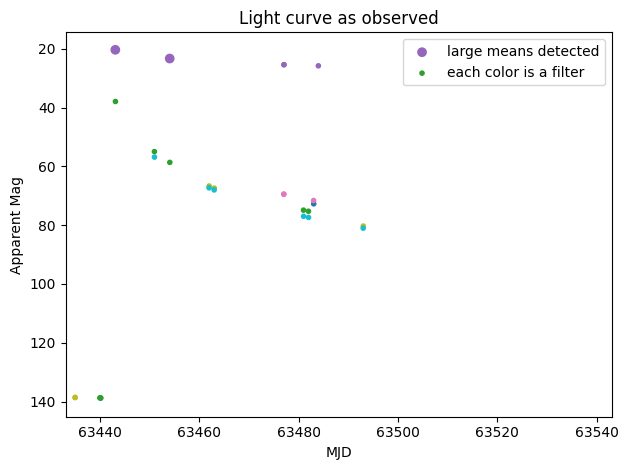

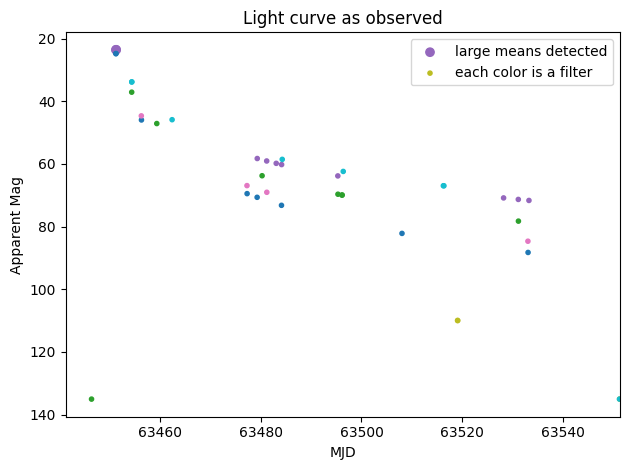

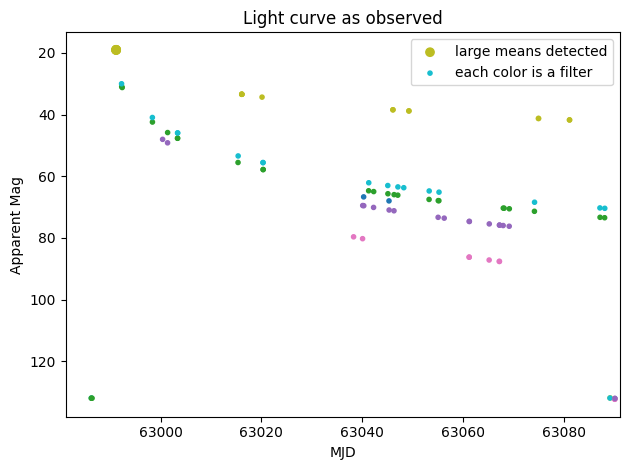

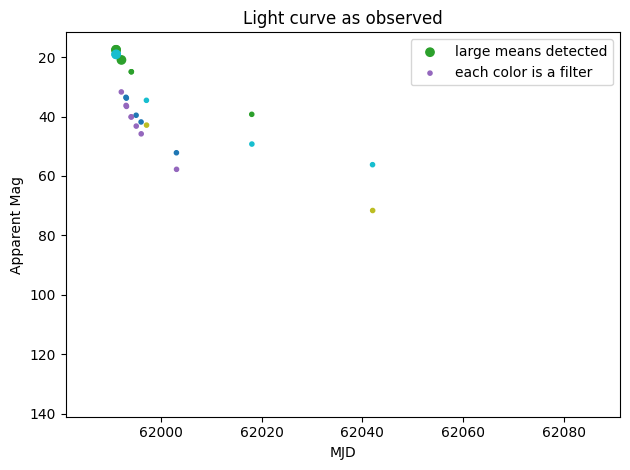

In [211]:
detected_df = df_obs_arr[df_obs_arr['detected']==True]
print(len(detected_df))

for i, row in detected_df.iterrows():
    plot_observed_light_curve(row)

,sid,mjd_obs,mag_obs,snr_obs,filter,first_det_mjd,last_det_mjd,fade_time_days,sid,file_indx,ra,dec,distance_Mpc,peak_mjd,peak_mag,ebv,peak_time,detected
123,179,"[62670.09603477358, 63730.25649216285, 61581.2...","[138.73562731301513, 138.60592622639098, 138.6...","[2.1849413164960256e-46, 9.76374165773339e-47,...","[i, y, z, y, y, z, r, y, r, g, i, g, z, z, z, ...",63443.097512,63454.045978,14.972464,179,851,4.405593,0.0,751.121939,63443.097512,20.376678,0.173873,3585.573514,True
135,194,"[63229.14179669305, 64203.2334359272, 63107.14...","[135.06601123979044, 135.07071235077524, 135.0...","[1.877473138229695e-45, 7.111735381172652e-45,...","[y, z, y, y, y, z, z, i, i, y, g, u, i, z, z, ...",63451.302698,63451.303143,2.108568,194,43,0.126677,-1.172682,161.751473,63451.302698,23.535546,0.016647,3595.694575,True
156,226,"[62337.23719248868, 61364.026493349484, 61364....","[131.89455213083605, 132.03326944412484, 132.0...","[1.5739758677986183e-43, 7.173510569016352e-44...","[z, r, r, z, i, y, r, r, i, u, i, i, r, y, y, ...",62991.172726,62991.197459,3.681971,226,719,4.78602,-0.661858,34.610896,62991.172726,19.023307,0.124828,3134.015487,True
269,394,"[64093.38640298782, 62238.41614144662, 64206.0...","[133.25416964074157, 132.64889450158012, 132.6...","[6.80669251436586e-44, 1.1190122036029723e-43,...","[r, i, i, g, r, i, i, z, g, i, g, z, r, r, z, ...",61991.121007,61992.193354,3.176971,394,189,4.552855,-0.452817,22.179659,61991.121007,17.544772,0.934488,2135.516383,True


In [131]:


rates = [estimate_fade_rate(shared_lc_model, i, "r", t1=1.0, t2=10.0) for i in range(len(shared_lc_model.data))]
plt.hist(rates, bins=30)
plt.xlabel("Fade Rate (mag/day)")
plt.ylabel("Number of Light Curves")
plt.title("Empirical Fade Rates from Synthetic GRB Light Curves")
plt.grid(True)
plt.show()

NameError: name 'estimate_fade_rate' is not defined

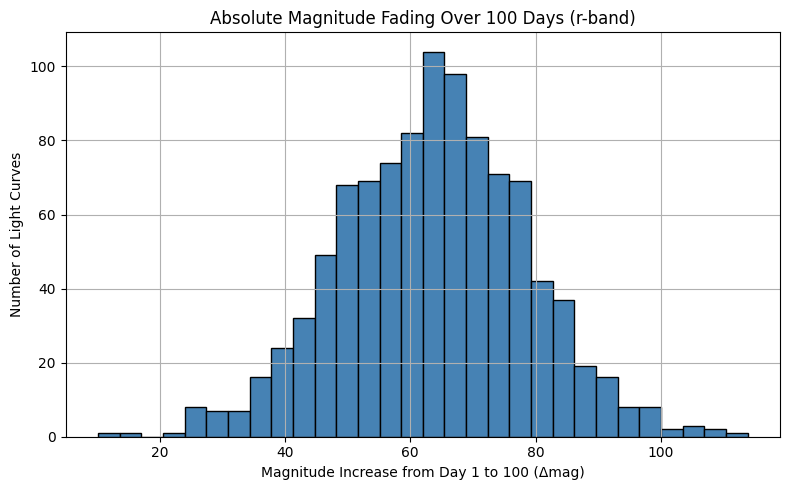

In [128]:
def compute_absolute_fade(lc_model, filtername="r", t1=1.0, t2=100.0):
    """
    Compute Δmag = m(t2) - m(t1) in a given filter for all GRB light curves.
    """
    deltas = []
    for i in range(len(lc_model.data)):
        mag_t1 = np.interp(t1, lc_model.data[i][filtername]['ph'],
                                 lc_model.data[i][filtername]['mag'])
        mag_t2 = np.interp(t2, lc_model.data[i][filtername]['ph'],
                                 lc_model.data[i][filtername]['mag'])
        deltas.append(mag_t2 - mag_t1)
    return np.array(deltas)

delta_mags = compute_absolute_fade(shared_lc_model, filtername='r')

plt.figure(figsize=(8, 5))
plt.hist(delta_mags, bins=30, color='steelblue', edgecolor='black')
plt.xlabel("Magnitude Increase from Day 1 to 100 (Δmag)")
plt.ylabel("Number of Light Curves")
plt.title("Absolute Magnitude Fading Over 100 Days (r-band)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [130]:
df = pd.read_csv("GRBafterglows_output/ObsRecords_four_roll_v4.3.1_10yrs.csv", converters={'filter': eval})
# print(df.iloc[2048]['filter'])  # Example for row 2049


In [171]:

# Load the CSV (after fixing how arrays were saved, as discussed)
df = pd.read_csv("GRBafterglows_output/ObsRecords_four_roll_v4.3.1_10yrs.csv")

# Count how many are detected vs not
detected_counts = df['detected'].value_counts()

print("Detection Summary:")
print(detected_counts)

# Optionally print percentages
print("\nDetection Percentages:")
print(detected_counts / len(df) * 100)


Detection Summary:
detected
False    159
True     131
Name: count, dtype: int64

Detection Percentages:
detected
False    54.827586
True     45.172414
Name: count, dtype: float64


In [172]:
print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique()) #


mjd_obs           174
mag_obs           174
snr_obs           174
filter            174
first_det_mjd       1
last_det_mjd        1
rise_time_days      1
fade_time_days      1
sid                 1
file_indx           1
ra                  1
dec                 1
distance_Mpc        1
peak_mjd            1
peak_mag            1
ebv                 1
peak_time           1
detected            1
dtype: int64


/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_87009/929288799.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(pd.DataFrame(obs_records).applymap(lambda x: len(x) if hasattr(x, '__len__') and not isinstance(x, str) else 'scalar').nunique()) #


In [145]:
#Checking lengths of each variable have the same length. - no return means just variable per sky positions. 
for i, record in enumerate(obs_records):
    lengths = [len(record[k]) for k in ['mjd_obs', 'mag_obs', 'snr_obs', 'filter']]
    if len(set(lengths)) > 1:
        print(f"Inconsistent lengths for index {i}: {lengths}")


In [ ]:
df

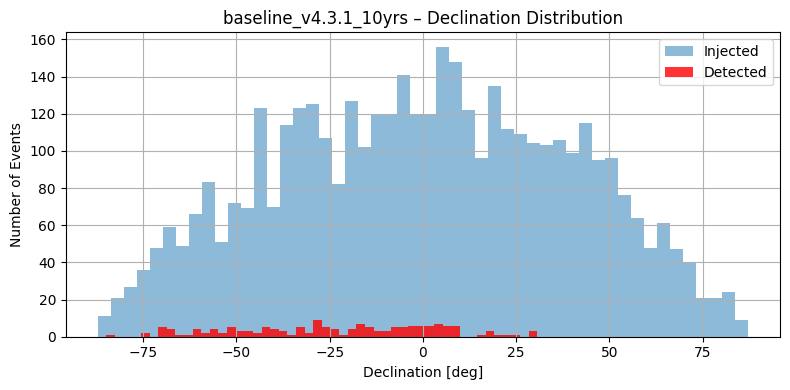

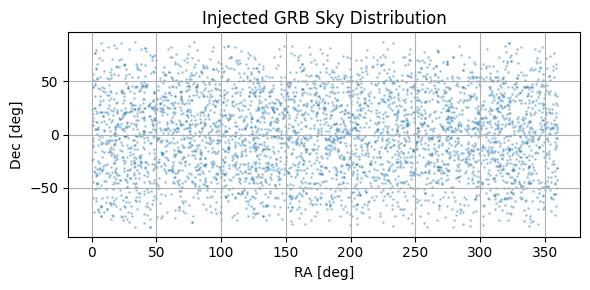

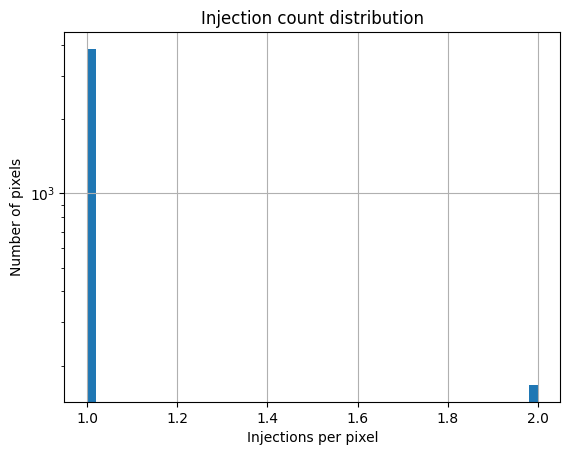

In [144]:
plt.figure(figsize=(8, 4))

plt.hist(np.degrees(slicer.slice_points['dec']), bins=50, alpha=0.5, label='Injected')
plt.hist(np.degrees(np.array(decs)[detected_flags]), bins=50, alpha=0.8, label='Detected', color='red')
plt.xlabel("Declination [deg]")
plt.ylabel("Number of Events")
plt.title(f"{cadence} – Declination Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(np.degrees(ra_rad), np.degrees(dec_rad), s=1, alpha=0.3)
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.title("Injected GRB Sky Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.hist(injected_map[injected_map > 0], bins=50, log=True)
plt.xlabel("Injections per pixel")
plt.ylabel("Number of pixels")
plt.title("Injection count distribution")
plt.grid(True)
plt.show()



## Per year - depreciated


In [ ]:
# ---- Per Year Configuration ----
year_intervals = [
    (1, 365), (365, 730), (730, 1095), (1095, 1460), (1460, 1825),
    (1825, 2190), (2190, 2555), (2555, 2920), (2920, 3285), (3285, 3652)
]
first = 1

def filter_population_by_mjd(slicer, mjd_start, mjd_end, mjd0=59853.5):
    peak_times = slicer.slice_points['peak_time'] + mjd0
    mask = (peak_times >= mjd_start) & (peak_times < mjd_end)
    ra = slicer.slice_points['ra'][mask]
    dec = slicer.slice_points['dec'][mask]
    new_slicer = UserPointsSlicer(ra=ra, dec=dec, badval=0)
    new_slice_points = {k: v[mask] for k, v in slicer.slice_points.items()}

    # Resequence the SID to be 0 through len−1 for metric indexing
    new_slice_points['sid'] = np.arange(len(ra))
    new_slicer.slice_points = new_slice_points
    return new_slicer

yearly_detection_counts = []
for cadence in cadences:
    print(f"\n=== Running GRB Detect-only for cadence: {cadence} ===")
    runName = cadence
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(grbs_dir, f"PY_Metric_temp_{cadence}")
    #opsdb = db_path

    os.makedirs(outDir, exist_ok=True)
    resultsDb = ResultsDb(out_dir=outDir)
    
    for yr, (t0, t1) in enumerate(year_intervals):
        print(f"\n--- Year {yr+1}: Days {t0} to {t1} ---")

        # Filter the population to this year's time window
        #slicer_year = filter_population_by_time(slicer, t0, t1)
        # Convert night range to approximate MJD offset from mjd0
        mjd_start = t0 + 59853.5  # or your custom mjd0
        mjd_end   = t1 + 59853.5
        slicer_year = filter_population_by_mjd(slicer, mjd_start, mjd_end)
        print(f"Year {yr+1}: {len(slicer_year.slice_points['ra'])} events passed time filter.")


        
        # Add multi-band metrics
        multi_metrics = [
            GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand", lc_model=shared_lc_model),
            #GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand", lc_model=shared_lc_model)
        ]



        for metric in multi_metrics:
            mb_key = f"{runName}_{metric.__class__.__name__}_Yr{yr+1}"
            bundle = metric_bundles.MetricBundle(
                metric, slicer_year, f'night >= {t0} and night < {t1}',
                file_root=mb_key, plot_funcs=[],
                summary_metrics=[metrics.SumMetric()]
            )
        
            bd = maf.metricBundles.make_bundles_dict_from_list([bundle])
            bgroup = metric_bundles.MetricBundleGroup({mb_key: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
            bgroup.run_all()
            if first:
                df_yr = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
                df_yr["run"] = runName
                df_yr["year"] = yr
                first = 0
            else:
                _ = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
                _["run"] = runName  
                _["year"] = yr
                df_yr = pd.concat([df_yr, _])
            # Healpix plotting
    
            nside = slicer_year.nside if hasattr(slicer_year, 'nside') else 64
            npix = hp.nside2npix(nside)
            injected_map = np.zeros(npix)
            detected_map = np.zeros(npix)
            
            ra_rad = slicer_year.slice_points['ra']
            dec_rad = slicer_year.slice_points['dec']
            pix_inds = hp.ang2pix(nside, 0.5 * np.pi - dec_rad, ra_rad)
            
            for i, pix in enumerate(pix_inds):
                injected_map[pix] += 1
                if bundle.metric_values[i] == 1:
                    if np.random.rand() < 0.001:
                        print(f"[DEBUG] Detected RA, Dec: {np.degrees(ra_rad[i]):.2f}, {np.degrees(dec_rad[i]):.2f}")
                    detected_map[pix] += 1
            
                        

            eff_map = np.zeros(npix)
            mask = injected_map > 0
            eff_map[mask] = detected_map[mask] / injected_map[mask]
            eff_map[~mask] = hp.UNSEEN
            
            hp.mollview(eff_map, title=f"{runName} – {metric.metricName} Efficiency", unit='Efficiency', cmap='viridis')
            hp.graticule()
            #plt.tight_layout()
            plt.show()

            # Count detections per year
            metric_vals = bundle.metric_values
            n_total = len(metric_vals)
            n_detected = np.sum(metric_vals == 1)
            
            print(f"[SUMMARY] Year {yr+1}: {n_detected} / {n_total} events detected.")
            
            # Store results
            if 'yearly_detection_counts' not in locals():
                
                yearly_detection_counts.append((yr + 1, n_detected, n_total))

    years, detected_counts, total_counts = zip(*yearly_detection_counts)
    plt.figure(figsize=(8, 5))
    plt.bar(years, detected_counts, color='mediumblue', alpha=0.7, label='Detected')
    plt.plot(years, total_counts, 'ko--', label='Injected (per year)')
    plt.xlabel("Year")
    plt.ylabel("Number of GRBs Detected")
    plt.title("GRB Afterglow Detections Per Year")
    plt.xticks(ticks=years)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
df_yr